In [1]:
!pip install gensim
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 29.5 MB/s eta 0:00:00


In [2]:
!pip install -U -q google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.7/724.7 kB 14.7 MB/s eta 0:00:00


In [3]:
from google import genai
from google.genai import types

client = genai.Client(api_key="")

In [4]:
for m in client.models.list():
  if 'embedContent' in m.supported_actions:
    print(m.name)

models/gemini-embedding-001


In [5]:
MODEL_ID = "gemini-embedding-001" # @param ["gemini-embedding-001", "text-embedding-004"] {"allow-input":true, isTemplate: true}


Dataset

In [6]:
from google.colab import files
uploaded=files.upload()

Saving IMDB Dataset.csv.zip to IMDB Dataset.csv.zip


In [7]:
!unzip 'IMDB Dataset.csv.zip'

Archive:  IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


In [8]:
df=pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'sentiment' column to create 'sentiment_label'
df['sentiment_label'] = le.fit_transform(df['sentiment'])

# Display the first few rows with the new column and the mapping
display(df.head())
print("Sentiment Label Mapping:")
for i, sentiment in enumerate(le.classes_):
    print(f"{sentiment}: {i}")

,review,sentiment,sentiment_label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


Sentiment Label Mapping:
negative: 0
positive: 1


In [10]:
print(df.columns)


Index(['review', 'sentiment', 'sentiment_label'], dtype='object')


In [11]:
import nltk
nltk.download('punkt') # word_tokenize needs 'punkt'
nltk.download('stopwords') # stopwords.words needs 'stopwords'
nltk.download('punkt_tab') # This is explicitly needed by the error message

from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

stop_words=set(stopwords.words('english'))
def preprocess(text):
  text=text.lower()
  text=''.join([word for word in text if word not in string.punctuation])
  tokens=word_tokenize(text)
  tokens=[word for word in tokens if word not in stop_words]
  return ' '.join(tokens)
df['preprocessed_review']=df['review'].apply(preprocess)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [12]:
df.head()

,review,sentiment,sentiment_label,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,1,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter matteis love time money visually stunni...


In [13]:
df1=df[['preprocessed_review','sentiment_label']]
X_train,X_test,y_train,y_test=train_test_split(df1['preprocessed_review'],df1['sentiment_label'],test_size=0.2,random_state=42)

Embeddings

In [14]:
from tqdm.auto import tqdm
from google.genai import types

tqdm.pandas()

import numpy as np
import math

def make_embed_text_fn(model):

    def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLASSIFICATION and embed the batch of texts
        result = client.models.embed_content(model=model,
                                            contents=[texts],
                                            config=types.EmbedContentConfig(
                                                task_type="CLASSIFICATION")).embeddings
        return np.array([embedding.values for embedding in result])

    return embed_fn


def create_embeddings(df):
    embed_fn = make_embed_text_fn(MODEL_ID)

    batch_size = 25  # at most 25 requests can be in one batch
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["preprocessed_review"].iloc[i : i + batch_size].tolist()
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df

In [15]:
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()


def make_embed_text_fn(model):

    def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLASSIFICATION and embed the batch of texts
        result = client.models.embed_content(model=model,
                                            contents=texts, # Expects a list of strings for batching
                                            config=types.EmbedContentConfig(
                                                task_type="CLASSIFICATION")).embeddings
        return np.array([embedding.values for embedding in result])

    return embed_fn

def create_embeddings(df):
    embed_fn = make_embed_text_fn(MODEL_ID)

    batch_size = 25  # Recommended batch size for embedding
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["preprocessed_review"].iloc[i : i + batch_size].tolist()
        # Handle potential empty batch at the end
        if not batch:
            continue
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df

In [16]:
trainX=pd.DataFrame(X_train,columns=['preprocessed_review'])
testX=pd.DataFrame(X_test,columns=['preprocessed_review'])

In [17]:
model='models/embedding-001'
df_train=create_embeddings(trainX.head(50))
df_test=create_embeddings(testX.head(50))

  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipython-input-384014908.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Embeddings"] = all_embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipython-input-384014908.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Embeddings"] = all_embeddings


In [18]:
 df_train

,preprocessed_review,Embeddings
39087,thats kept asking many fights screaming matche...,"[-0.01304915, -0.0135524, -0.008534507, -0.061..."
30893,watch entire movie could watch entire movie st...,"[-0.012056573, -0.0030875134, 0.010026926, -0...."
45278,touching love story reminiscent in mood love ...,"[-0.016477965, -0.00032033896, 0.005469079, -0..."
16398,latterday fulci schlocker totally abysmal conc...,"[0.0007849604, 0.03037281, -0.0025947273, -0.0..."
13653,first firmly believe norwegian movies continua...,"[-0.005146648, 0.0048875, 0.006584519, -0.0631..."
13748,dont know movie received many positive reviews...,"[-0.0032503316, 0.0077306773, 0.014566462, -0...."
23965,nightmare weekend stars cast ridiculous actors...,"[0.0021439902, -0.0089574745, 0.010568769, -0...."
45552,spoiler alertbr br soooo arnies really good gu...,"[0.0005477935, -0.016209045, 0.008958759, -0.0..."
30219,people badmouthing film dont understand film b...,"[-0.0026143573, -0.009336178, 0.019585347, -0...."
24079,br br usual really looking forward new tvfilm ...,"[-0.0026408178, -0.017649539, 0.012120216, -0...."


In [19]:
import keras
from keras import layers

def build_classification_model(input_size: int,num_classes:int)->keras.Model:

    inputs =x= keras.Input(shape=(input_size,))
    x=layers.Dense(input_size,activation='relu')(x)
    x=layers.Dropout(0.3)(x)
    x=layers.Dense(input_size,activation='relu')(x)
    x=layers.Dropout(0.3)(x)
    x=layers.Dense(num_classes,activation='sigmoid')(x)
    return keras.Model(inputs,x)

In [20]:
embedding_size=len(df_train['Embeddings'].iloc[0])

classifier=build_classification_model(embedding_size,len(df['sentiment'].unique()))
classifier.summary()

classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3072)           │     9,440,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3072)           │     9,440,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         6,146 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,886,658 (72.05 MB)

 Trainable params: 18,886,658 (72.05 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
NUM_EPOCHS=20
BATCH_SIZE=32

x_train=np.stack(df_train['Embeddings'])
x_val=np.stack(df_test['Embeddings'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Get the corresponding labels for the subset of data used for training and validation
y_train_subset_sentiment = y_train.loc[df_train.index]
y_val_subset_sentiment = y_test.loc[df_test.index]

y_train_encoded = le.fit_transform(y_train_subset_sentiment)
y_val_encoded = le.transform(y_val_subset_sentiment)

callback=keras.callbacks.EarlyStopping(monitor='accuracy',patience=3,restore_best_weights=True)

history=classifier.fit(x=x_train,y=y_train_encoded,
                       validation_data=(x_val,y_val_encoded),
                       epochs=NUM_EPOCHS,
                       batch_size=BATCH_SIZE,
                       callbacks=[callback])

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4896 - loss: 0.6771 - val_accuracy: 0.9200 - val_loss: 0.4502
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 863ms/step - accuracy: 0.9258 - loss: 0.3867 - val_accuracy: 0.7800 - val_loss: 0.4666
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - accuracy: 0.9258 - loss: 0.2171 - val_accuracy: 0.9200 - val_loss: 0.2496
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.9050 - loss: 0.1978 - val_accuracy: 0.9200 - val_loss: 0.2536
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - accuracy: 0.9867 - loss: 0.0649 - val_accuracy: 0.8400 - val_loss: 0.3964
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 1.0000 - loss: 0.0311 - val_accuracy: 0.7400 - val_loss: 0.6357
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step - accuracy: 1.0000 - loss: 0.0284 - val_accuracy: 0.8600 - val_loss: 0.4563
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8600 - val_loss: 0.

In [22]:
classifier.evaluate(x=x_val,y=y_val_encoded,return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7225 - loss: 0.6318


{'accuracy': 0.7400000095367432, 'loss': 0.6357481479644775}

In [23]:
y_hat=classifier.predict(x=x_val)
y_hat=np.argmax(y_hat,axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


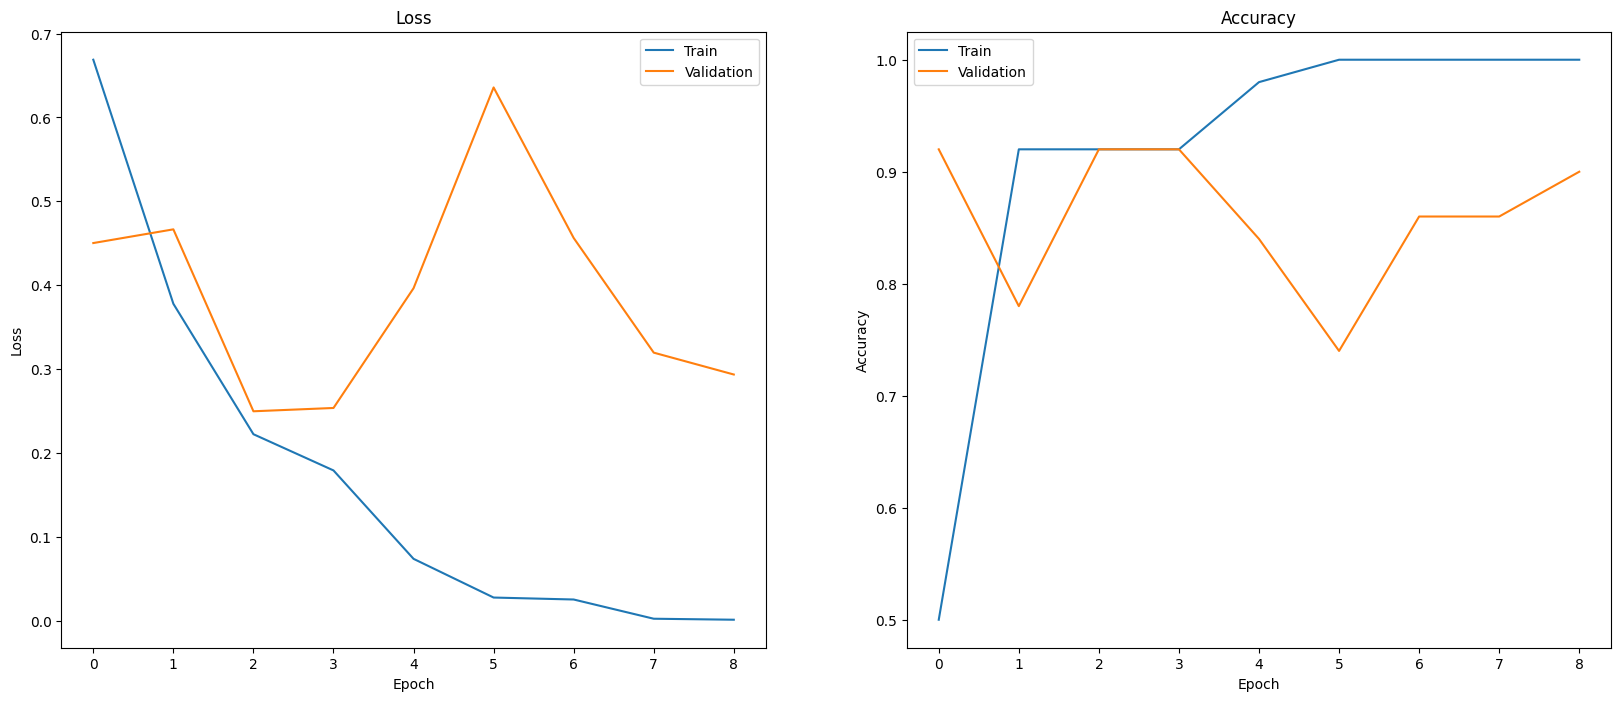

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

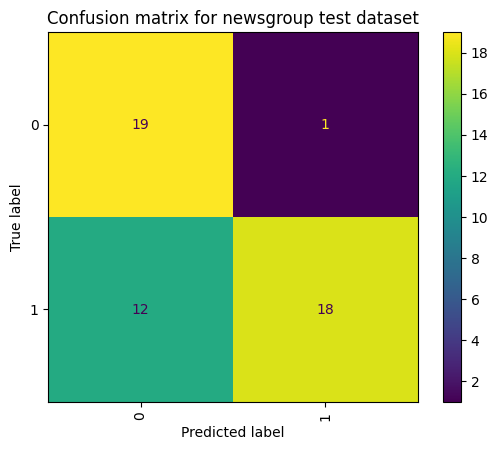

In [26]:
import sklearn.metrics as skmetrics

cm = skmetrics.confusion_matrix(y_val_encoded, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)

UNseen data

In [ ]:
text='direction is not upto the mark'
model=MODEL_ID # Use the correctly defined MODEL_ID

embedding=client.models.embed_content(model=model,
                              contents=[text],
                              config=types.EmbedContentConfig(
                                  task_type='CLASSIFICATION'
                              ))
y_hat=classifier.predict(np.array([embedding.embeddings[0].values]))
predicted_class_index = np.argmax(y_hat,axis=1)[0]

class_names=['Negative','Positive']
print(class_names[predicted_class_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Negative
